# Building a Multilayer Perceptron (Feed forward neural network)
This will be using micograd and the Value object


In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
class Value:

	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0 # will be changed
		self._backward = lambda: None # does chain rule at each step for backpropogation -- by default does nothing (lambda: None)
		self._prev = set(_children)
		self._op = _op
		self.label = label

	def __repr__(self):
		return f"Value(data={self.data})"
		
	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')

		# calculating gradient
		def _backward():
			self.grad += 1.0 * out.grad
			other.grad += 1.0 * out.grad
		out._backward = _backward

		return out
		
	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')

		# calculating gradient
		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward # karpathy made an oopsie here :)

		return out
	
	def tanh(self):
		x = self.data
		t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
		out = Value(t, (self, ), 'tanh')

		# calculating gradient
		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward # another oopsie here too :)
		
		return out
	
	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)
		topo

		# let's calculate the gradients!
		self.grad = 1.0 # base case
		for node in reversed(topo):
			node._backward()

	def __pow__(self, other):
		assert isinstance(other, (int, float)), "only supporting int/float powers for now"
		out = Value(self.data**other, (self,), f'**{other}')

		def _backward():
			self.grad += other * (self.data ** (other - 1)) * out.grad
		out._backward = _backward

		return out
	
	def __rmul__(self, other):
		return self * other
	
	def __radd__(self, other):
		return self + other
	
	def __truediv__(self, other):
		return self * other**-1
	
	def __neg__(self):
		return self * -1
	
	def __sub__(self, other):
		return self + (-other)
	
	def exp(self):
		x = self.data
		out = Value(math.exp(x), (self, ), 'exp')
	
	


In [8]:
from graphviz import Digraph

def trace(root):
	# builds a set of all nodes and edges in a graph
	nodes, edges = set(), set()
	def build(v):
		if v not in nodes:
			nodes.add(v)
			for child in v._prev:
				edges.add((child, v))
				build(child)
	build(root)
	return nodes, edges

def draw_dot(root):
	dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

	nodes, edges = trace(root)
	for n in nodes:
		uid = str(id(n))
		# for any value in the graph, create a rectangular ('record') node for it
		dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
		if n._op:
			# if this value is a result of some operation, create an op node for it
			dot.node(name = uid + n._op, label = n._op)
			# and connect this node to it
			dot.edge(uid + n._op, uid)
	for n1, n2 in edges:
		# connect n1 to the op node n2
		dot.edge(str(id(n1)), str(id(n2)) + n2._op)

	return dot

In [4]:
import random
class Neuron:
    """
    nin: number of inputs
    """
    def __init__(self, nin): # initializer
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # creates a weight (random value between -1 and 1) for every input
        self.b = Value(random.uniform(-1,1)) # creates a bias (random value between -1 and 1)

    def __call__(self, x): # when you call a Neuron and pass in a list it runs this function
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # creating activation value (multiplying each w by each x and summing them up) -- also starts with bias b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

# example
#x = [2.0, 3.0]
#n = Neuron(2) # initilize 2 neurons
#n(x)

## Creating a layer of neurons
Now that we've built a single neuron we need to create a layer of them (each layer will connect to every neuron in the previous and next layer but will not connect neurons in the same layer together)

In [11]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # below code does the same thing
        """params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
            return params"""
    
#x = [2.0, 3.0]
#n = Layer(2, 3)
#n(x)

## Creating an MLP
Now we link together layers to create a multi layer perceptron

In [12]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9167720066460415)

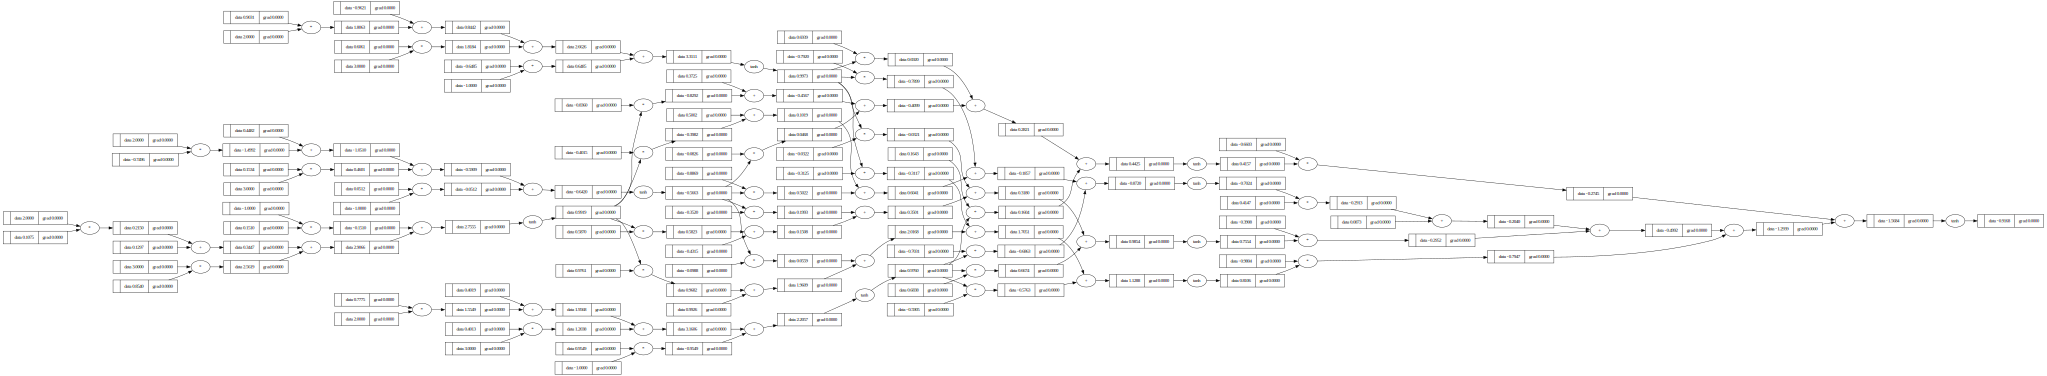

In [13]:
draw_dot(n(x))

## Adding in gradients
Now that we can build an MLP, its time to integrate a dataset and loss function

We will be creating a basic binary classifier neural net

In [14]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets -- we want the first row of inputs to output 1.0, the next two rows to output -1.0, and last last row 1.0

In [15]:
# forward pass
ypred = [n(x) for x in xs]
ypred # gives the outputs on the for inputs w/o training

[Value(data=-0.9167720066460415),
 Value(data=-0.47291165552919356),
 Value(data=-0.6718001805894823),
 Value(data=-0.8820461044665309)]

In [16]:
loss_eq = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # mean squared error loss
loss = sum(loss_eq)
loss

Value(data=7.601649709137607)

In [65]:
# recalculating loss after changing parameters
ypred = [n(x) for x in xs]
loss_eq = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # mean squared error loss
loss = sum(loss_eq)
loss

Value(data=6.945668642893605)

In [17]:
# backward pass
loss.backward()

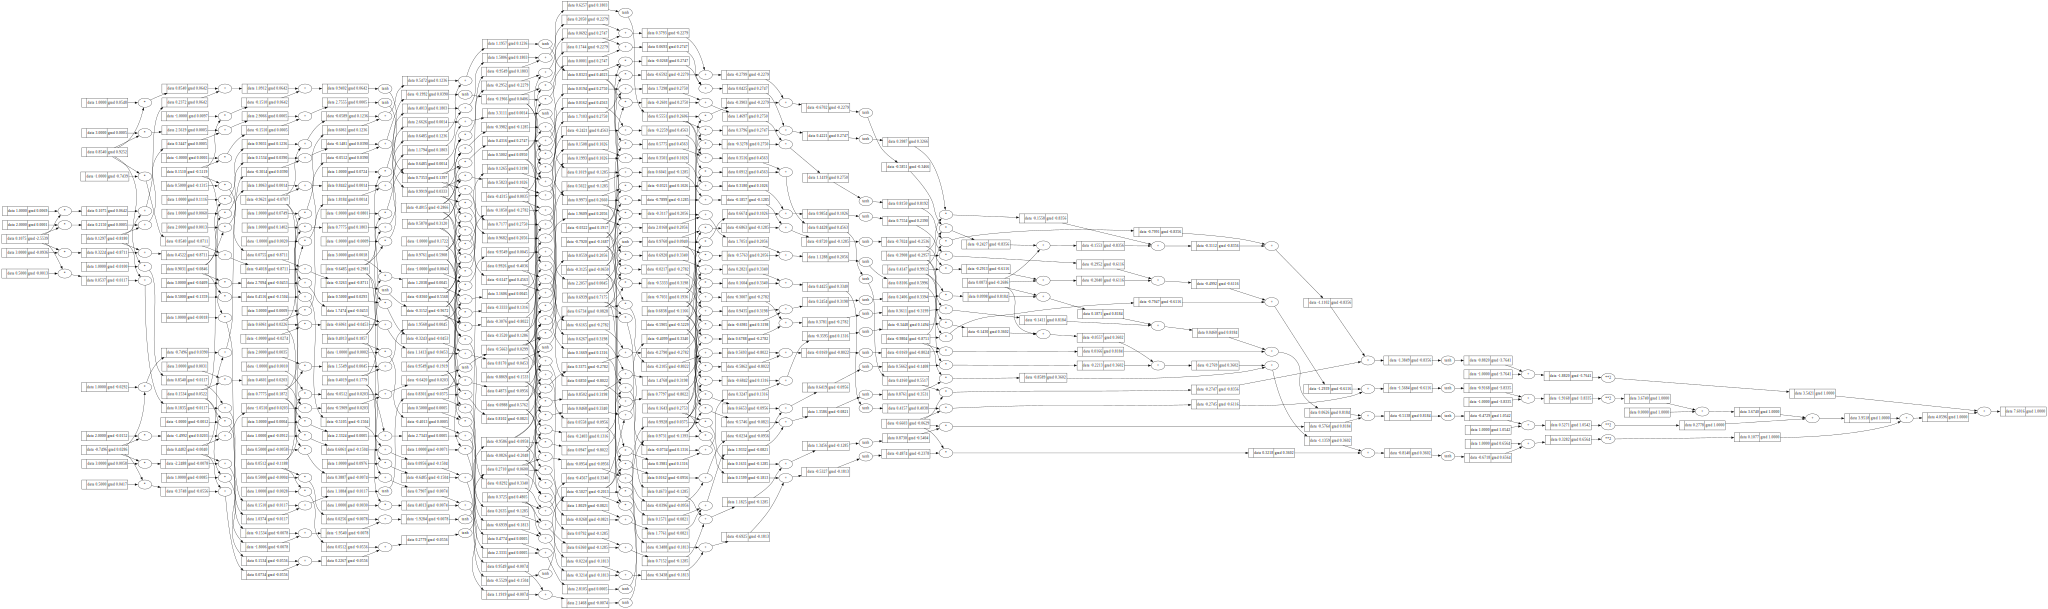

In [21]:
draw_dot(loss)

In [19]:
n.layers[0].neurons[0].w[0].grad

-2.553879532735329

### What does that gradient value mean?
A negative gradient means that increasing the value of the weight by a little bit will decrease the loss (which is what we want) and a positive means the opposite

In [20]:
# using parameters -- outputs how many parameters there are
len(n.parameters())

41

In [62]:
# minimizing loss by nudging the parameters
for p in n.parameters():
    p.data += -0.01 * p.grad # step size in direction of lower loss * grad

# The final neural network setup and training

In [78]:
# reinitialize the neural network
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9678902675381541)

In [ ]:
# initialize data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# initialize target
ys = [1.0, -1.0, -1.0, 1.0] # desired targets -- we want the first row of inputs to output 1.0, the next two rows to output -1.0, and last last row 1.0

In [153]:
# train the network
for i in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss_eq = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # mean squared error loss
    loss = sum(loss_eq)
    print(i, loss.data)

    # MISSED STEP (KARPATHY MADE ANOTHER OOPSIE)
    # we need to zero all the gradients before we can do anothert backward pass (since they add on to each other)
    for p in n.parameters():
        p.grad = 0.0;

    # backward pass
    backward = loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -1 * p.grad
    #print("predictions:", ypred)

0 3.337793355149112e-05
1 3.33163627587975e-05
2 3.325501328888028e-05
3 3.319388396118068e-05
4 3.313297360347317e-05
5 3.307228105181128e-05
6 3.301180515044117e-05
7 3.2951544751733573e-05
8 3.289149871611115e-05
9 3.2831665911984874e-05
10 3.277204521567449e-05
11 3.271263551134861e-05
12 3.265343569094763e-05
13 3.25944446541263e-05
14 3.253566130817834e-05
15 3.247708456797822e-05
16 3.241871335590768e-05
17 3.236054660179391e-05
18 3.230258324285384e-05
19 3.2244822223613276e-05


In [135]:
ypred # predictions

[Value(data=0.9963581502135094),
 Value(data=-0.9973904789698402),
 Value(data=-0.9943920049687593),
 Value(data=0.9940182130021666)]